In [1]:
import numpy as np
import random
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import scatter, mask_to_index, index_to_mask, degree, to_networkx
from torch_geometric.data import Data, DataLoader
from torch_geometric.data import Dataset
import torch_geometric.transforms as T
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
import torch.nn.functional as F
from torch import optim
from torch_scatter import scatter_sum, scatter_mean
import pickle
import matplotlib.pyplot as plt
import copy
from utils.infilling_util import trim_tree_to_binary, compute_kept_times, build_infill_tree, \
    label_train_val_test_split, read_split_indices, check_dataset_integrity, \
    find_ancestor_descendent_vn, get_mass_c_vmax_scale_only, split_tree_dataset, \
    build_infill_dataset
from models.model_infilling import TreeNodeClassifier, train_eval_classifier, eval_classifier
import math
from torch_geometric.utils import subgraph
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import h5py
from collections import defaultdict
import time
import ast
from sklearn.neighbors import KNeighborsClassifier
from utils.tree_util import split_dataloader, subset_data_features
import copy

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

Pytorch Geometric is available = True. Return list of PyG.Data = True


In [2]:
from sklearn.metrics import r2_score

def bootstrap_r2(y_true, y_pred, n_bootstrap=1000, seed=None):
    rng = np.random.default_rng(seed)
    n_samples = len(y_true)
    r2_values = []

    for _ in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        r2 = r2_score(y_true[indices], y_pred[indices])
        r2_values.append(r2)

    r2_values = np.array(r2_values)
    mean_r2 = np.mean(r2_values)
    std_r2 = np.std(r2_values)
    return mean_r2, std_r2


def bootstrap_acc(y_true, y_pred, n_bootstrap=1000, seed=None):
    rng = np.random.default_rng(seed)
    n_samples = len(y_true)
    acc_values = []

    for _ in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        acc = np.mean(y_true[indices] == y_pred[indices])
        acc_values.append(acc)

    acc_values = np.array(acc_values)
    return acc_values.mean(), acc_values.std()
    #ci_lower = np.percentile(r2_values, 2.5)
    #ci_upper = np.percentile(r2_values, 97.5)

    #return mean_r2, (ci_lower, ci_upper), r2_values

### Data splits

In [ ]:
path = "/mnt/home/thuang/ceph/playground/datasets/merger_trees_1000_feat_1e13/SAM_trees"
n_sample = 25
dataset = torch.load(f"{path}/prune_trim_dataset_nsample={n_sample}.pt")

In [5]:
len(dataset)

25000

In [6]:
dataset_lb = [data for data in dataset if data.x.shape[0] > 100]
len(dataset_lb)

24996

In [8]:
incomplete_idxs = check_dataset_integrity(dataset_lb)

✅ All Data objects passed the integrity check.


In [9]:
torch.save(dataset_lb, "/mnt/home/thuang/ceph/playground/datasets/merger_trees_1000_feat_1e13/SAM_trees/all_trees_24996.pt")

In [14]:
dataset_lb = torch.load( "/mnt/home/thuang/ceph/playground/datasets/merger_trees_1000_feat_1e13/SAM_trees/all_trees_24996.pt")
len(dataset_lb)

24996

In [15]:
sizes = [data.x.shape[0] for data in dataset_lb]
min(sizes), max(sizes)

(121, 37865)

In [6]:
train_lhs, val_lhs, test_lhs = read_split_indices("/mnt/home/thuang/ceph/playground/datasets/merger_trees_1000_feat_1e13/SAM_trees/split_indices.txt")

In [7]:
len(train_lhs), len(val_lhs), len(test_lhs)

(600, 204, 196)

In [8]:
#split into train/val/test 
train_loader, val_loader, test_loader = split_dataloader(dataset, train_lhs, val_lhs, test_lhs,
                                                         train_n_sample=1, time=True, no_mass=True)

normalizing for mean 0 , std 1 across all trees!
train_size=600, val_size=204, test_size=196
sampled train data view = Data(x=[363, 3], edge_index=[2, 362], edge_attr=[362, 1], y=[1, 2], num_nodes=363, lh_id=0, mask_main=[94], node_halo_id=[363, 1])


/mnt/home/thuang/playground/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Simple Warm-up task: merger node binary classification
Data: 
- pre-binarize: take the tree from full time scales, binarize it by keeping the most massive two ancesotors if there are $>2$ ancestors
- coarsen: drop the nodes from even time scales (i.e. ensure we retain the current time $t=1$, aka the root), and arrive at the coarsened tree. The dropped MERGER nodes are saved as in a dictionary $D = \{child(m): m\}$  where $child(m)$ stores the information of the child node of $[m]$ (i.e. the outgoing node).
- post-binarize: take the coarsened tree, binarize it again and  arrive at the tree $\cal{T}([n], E, X)$
- find merger nodes $M \subset [n]$
- add virtual nodes: for each merger node $n \in M$, add a virtual node $v(n)$ with 3 virtual edges flowing from $n$ and the ancestors of $n$; for each virtual node $v(n)$, label it as $1$ if $n \in D.keys()$, and otherwise zero. 

Task: Given T'([n]+M, E+3V', X), classify the virtual nodes

In [3]:

def visualize_trees(original_data, pruned_data, coarse_pruned_data, title):
    G_orig = to_networkx(original_data, to_undirected=False)
    G_pruned = to_networkx(pruned_data, to_undirected=False)
    G_coarse = to_networkx(coarse_pruned_data, to_undirected=False)

    pos_orig = graphviz_layout(G_orig, prog="dot")
    pos_pruned = graphviz_layout(G_pruned, prog="dot")
    pos_coarse = graphviz_layout(G_coarse, prog="dot")

    fig, axes = plt.subplots(1, 3, figsize=(20, 12), dpi=200)

    #node_colors = ["red" if original_data.node_halo_id[n].item() in original_data.mask_main else "skyblue" for n in G_orig.nodes()]
    #node_colors = ["red" if n in leaf_ids else "skyblue" for n in G_orig.nodes()]
    nx.draw(G_orig, pos=pos_orig, with_labels=False, arrows=True, arrowsize=1,
            ax=axes[0], node_color="skyblue", node_size=10)
    axes[0].set_title(f"Binary Tree (size={original_data.x.shape[0]})", fontsize=20)
    
    #prune_time = {i: f"{pruned_data.x[i,-1].item():.3f}" for i in range(pruned_data.x.shape[0])}
    nx.draw(G_pruned, pos=pos_pruned, with_labels=False, arrows=True,arrowsize=5,
            ax=axes[1], node_color='lightgreen', node_size=50)
    axes[1].set_title(f"Coarsen-Binary Tree (size={pruned_data.x.shape[0]})", fontsize=20)

    #coarse_time = {i: f"{coarse_pruned_data.x[i,-1].item():.3f}" for i in range(coarse_pruned_data.x.shape[0])}
    nx.draw(G_coarse, pos=pos_coarse, with_labels=False, arrows=True,arrowsize=5,
            ax=axes[2], node_color='orange', node_size=50)
    axes[2].set_title(f"Coarse Binary-Coarsen Tree (size={coarse_pruned_data.x.shape[0]})", fontsize=20)
    fig.suptitle(title)

    plt.savefig(f"Plots_trees/{original_data.root_halo_id}")
    plt.show()

In [4]:
def draw_infill_tree(infill_tree, node_size=10):
    G = to_networkx(infill_tree, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    #  Adjust red node positions
    new_pos = pos.copy()
    y_offset = 0.15  # How much higher to place the red nodes
    x_offset = 0.1
    num_nodes = infill_tree.x.shape[0]
    virtual_nodes = torch.arange(num_nodes)[infill_tree.vn_mask].tolist()
    for red_node in virtual_nodes:
        #print(red_node)
        neighbors = find_ancestor_descendent_vn(infill_tree, red_node)
        #print(neighbors)
        x1, y1 = pos[neighbors[0]]
        x2, y2 = pos[neighbors[1]]
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        new_pos[red_node] = (mid_x + x_offset, mid_y + y_offset)

    fig, ax = plt.subplots(figsize=(16, 12), dpi=150)

    node_colors = ["red" if n in virtual_nodes else "skyblue" for n in G.nodes()]
    labels = {}
    for vn in virtual_nodes:
        labels[vn] = int(infill_tree.label[vn].item())
    #node_colors = ["red" if n in leaf_ids else "skyblue" for n in G_orig.nodes()]
    nx.draw(G, pos=new_pos, with_labels=False, arrows=True, arrowsize=3,
            ax=ax, node_color=node_colors, node_size=node_size)    
    nx.draw_networkx_labels(G, pos=new_pos, labels=labels)
    plt.show()

In [5]:
#original node attributes to feed into ESP
def get_features_infill_tree(data, mode="train"):
    infill_tree = copy.deepcopy(data)
    results = {'lh_id': infill_tree.lh_id,
            'root_halo_id': infill_tree.node_halo_id[0].item(),
            'omega_m':infill_tree.y[0,0].item(),
            'sigma_8':infill_tree.y[0,1].item(),
            }

    vn_out_list = []
    vn_ancestor_list = []
    num_nodes = infill_tree.x.shape[0]

    virtual_nodes = torch.arange(num_nodes)[infill_tree.vn_mask].tolist()

    for vn in virtual_nodes:
        vn_out_id = find_ancestor_descendent_vn(infill_tree, vn, mode='descendent')
        vn_out_feat = infill_tree.x[vn_out_id[0],:]
        vn_out_list.append(vn_out_feat)

        vn_ancestor_id = find_ancestor_descendent_vn(infill_tree, vn)
        vn_ancestor_feat = infill_tree.x[vn_ancestor_id, :]
        vn_ancestor_list.append(vn_ancestor_feat)

    results['vn_descendent_feat'] = torch.stack(vn_out_list)
    results['vn_ancestor_feat'] = torch.stack(vn_ancestor_list) 
    results['vn_label'] = infill_tree.label[virtual_nodes].tolist()
    return results

In [ ]:
num_trees = 200
dataset_lb = torch.load( "/mnt/home/thuang/ceph/playground/datasets/merger_trees_1000_feat_1e13/SAM_trees/all_trees_24996.pt")
train_trees, val_trees, test_trees, dataset, ratio, kept_times = build_infill_dataset(dataset_lb, num_trees=num_trees, same_lh=False,
                                      infilling_file_name=f"infilling_trees_25k_{num_trees}",
                     infilling_ratios=f"infilling_merger_ratios_25k_{num_trees}.pkl")

/tmp/ipykernel_333392/2280447778.py:20: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


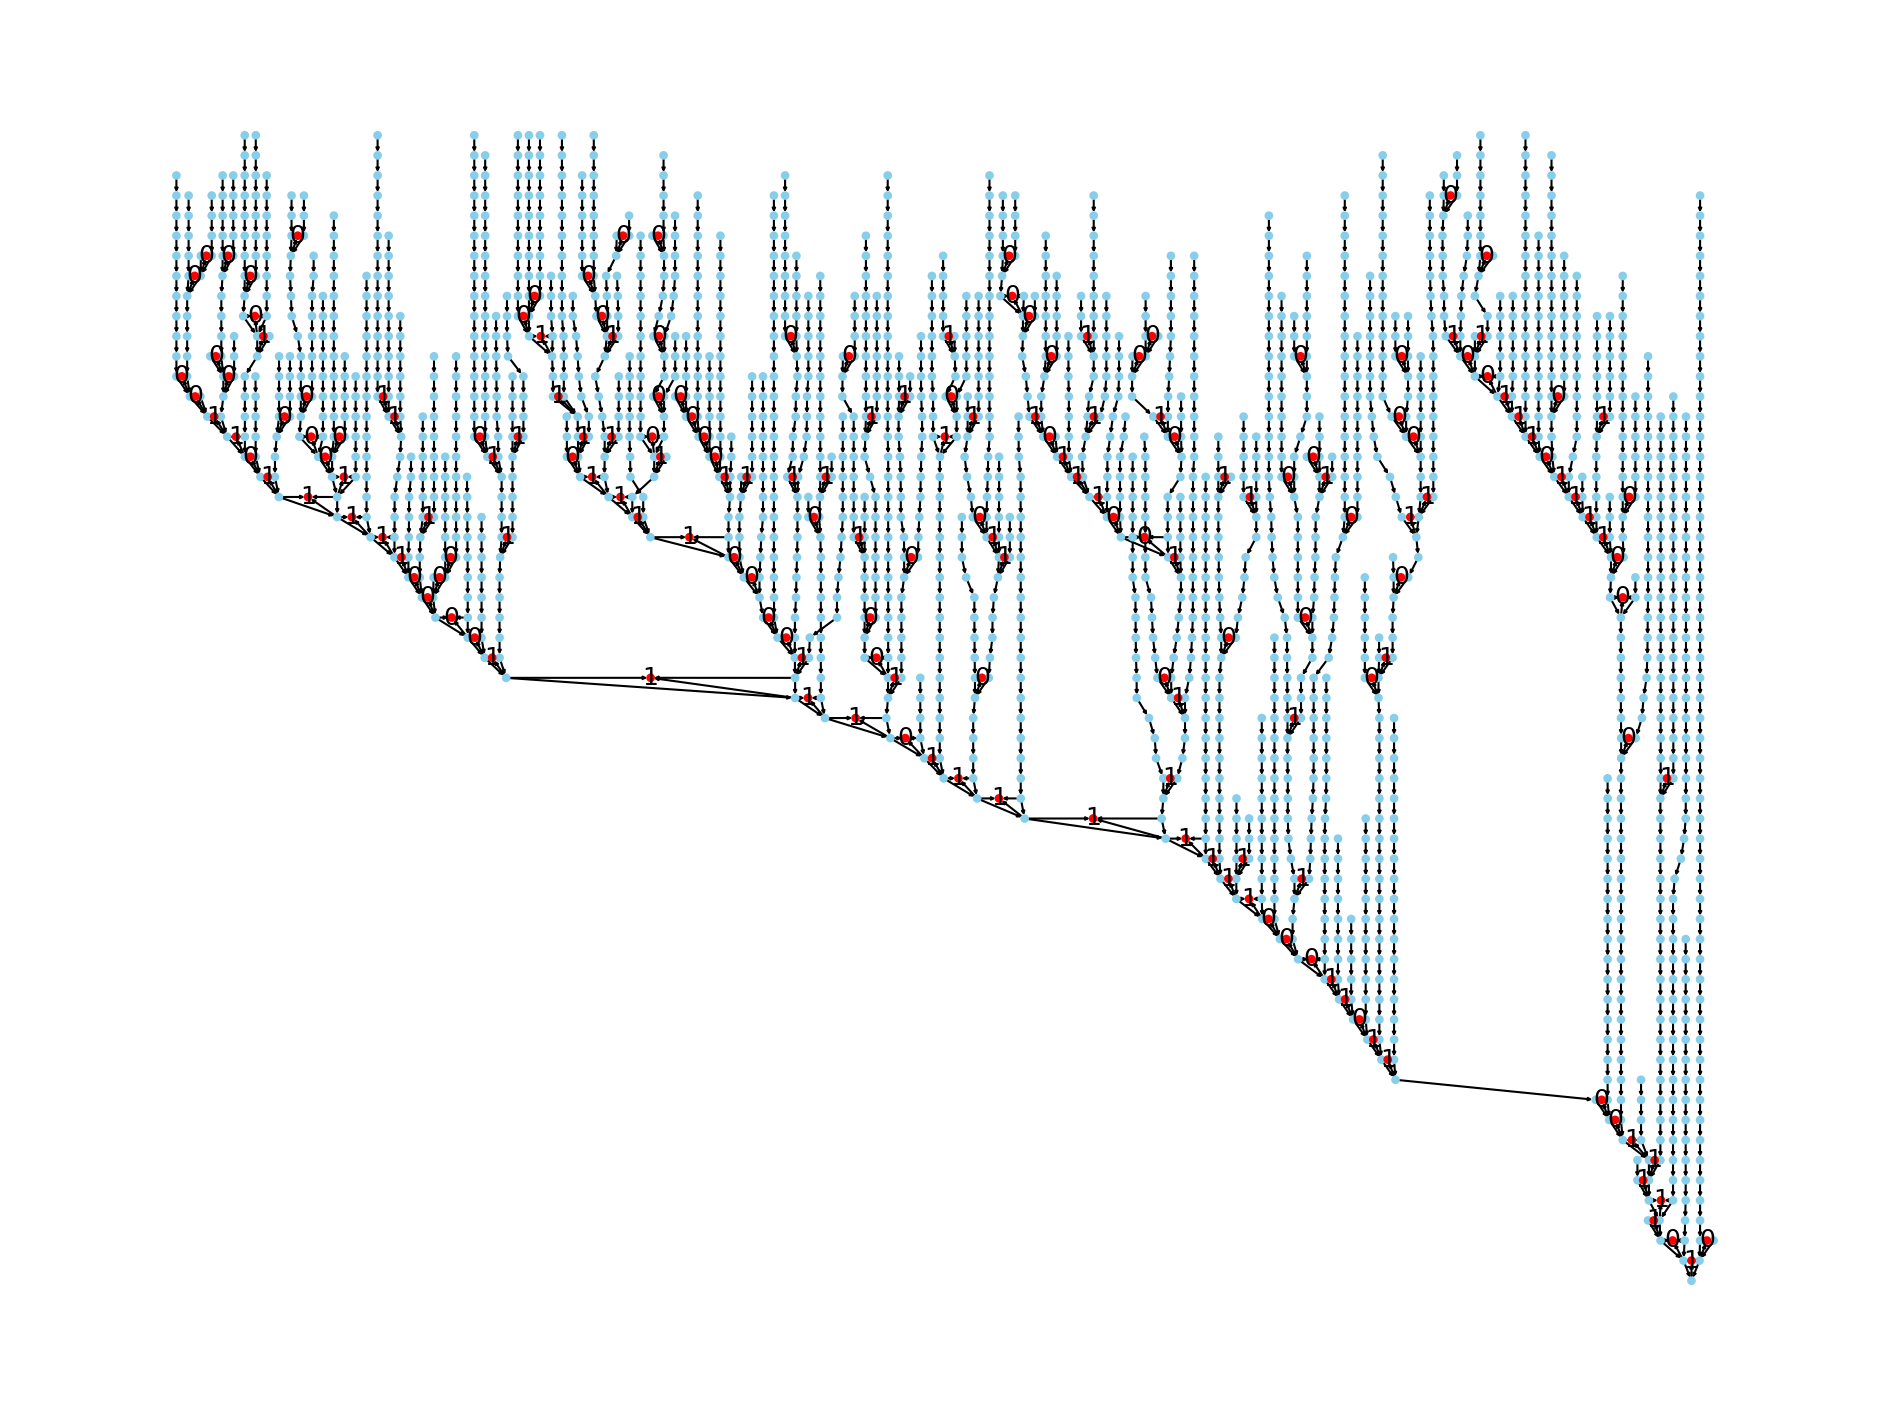

In [18]:
small = 0 #np.argmin(sizes)
#data = dataset[small]
infill_tree =  dataset[small] #build_infill_tree(data, kept_times, verbose=True)
draw_infill_tree(infill_tree)

In [19]:
(infill_tree.label == 1).sum(), (infill_tree.label == 0).sum()

(tensor(91), tensor(91))

### kNN baseline

In [6]:
def get_X_y_knn(results, feat_idx=[0]):
    X= torch.cat([results['vn_descendent_feat'].unsqueeze(1), results['vn_ancestor_feat']], dim=1)
    X = X[:,:, feat_idx].flatten(start_dim=1).numpy()
    y = np.array(results['vn_label'])
    #print(X.shape)
    return X, y
    
def run_knn_all(trainset, valset, testset, k_min=5, k_max=25, feat_idx=[0]):
    X_train_all, y_train_all = [], []
    X_val_all, y_val_all = [], [] 
    X_test_all, y_test_all = [], []
    
    for data in trainset:
        results = get_features_infill_tree(data)
        X, y = get_X_y_knn(results, feat_idx)
        X_train_all.append(X)
        y_train_all.append(y)
    
    for data in valset:
        results = get_features_infill_tree(data)
        X, y = get_X_y_knn(results, feat_idx)
        X_val_all.append(X)
        y_val_all.append(y) 
    
    for data in testset:
        results = get_features_infill_tree(data)
        X, y = get_X_y_knn(results, feat_idx)
        X_test_all.append(X)
        y_test_all.append(y) 
    
    X_train_all = np.concatenate(X_train_all)
    y_train_all = np.concatenate(y_train_all) #.reshape(-1,1)
    X_val_all = np.concatenate(X_val_all)
    y_val_all = np.concatenate(y_val_all) #.reshape(-1,1)
    X_test_all = np.concatenate(X_test_all)
    y_test_all = np.concatenate(y_test_all) #.reshape(-1,1)
    print(X_train_all.shape, y_train_all.shape)
    #print(y_train.shape, y_val.shape, y_test.shape)
    #hyper param search over k
    best_k = k_min
    best_val_acc = 0
    for k in range(k_min, k_max):
        nn = KNeighborsClassifier(n_neighbors=k)
        nn.fit(X_train_all, y_train_all)
        y_val_pred = nn.predict(X_val_all) 
        val_acc = np.mean(y_val_pred == y_val_all)
        #print(val_acc)
        #print(val_acc)
        if val_acc > best_val_acc:
            best_k = k 
            best_val_acc = val_acc 
    #print(f"best k = {best_k}, val_acc = {best_val_acc}")
    nn = KNeighborsClassifier(n_neighbors=best_k)
    nn.fit(X_train_all, y_train_all)
    y_test_pred = nn.predict(X_test_all) 
    acc_bootstrap_mean, acc_bootstrap_std = bootstrap_acc(y_test_all, y_test_pred, n_bootstrap=100)
    return np.mean(y_test_pred == y_test_all), acc_bootstrap_mean, acc_bootstrap_std

In [7]:
data_dir = f"/mnt/home/thuang/ceph/playground/datasets/SAM_trees"
train_path = f"{data_dir}/infilling_trees_25k_200_train.pt"
val_path = f"{data_dir}/infilling_trees_25k_200_val.pt"
test_path = f"{data_dir}/infilling_trees_25k_200_test.pt"
feat_idx = [0,1,2,3]

train_trees = subset_data_features(torch.load(train_path), feat_idx)
val_trees = subset_data_features(torch.load(val_path), feat_idx)
test_trees = subset_data_features(torch.load(test_path), feat_idx)


In [8]:
train_trees[0]

Data(x=[1967, 4], edge_index=[2, 2338], edge_attr=[1780, 1], y=[1, 2], lh_id=185, mask_main=[96], node_halo_id=[1781, 1], x_mean_excl_time=[3], x_std_excl_time=[3], label=[1967], vn_mask=[1967], vn_train_idx=[111], vn_val_idx=[37], vn_test_idx=[38])

In [12]:
acc_all, acc_boot_all, acc_boot_std_all = [], [], []

for idx in [[0], [1], [2], [3], [0,1,2,3]]:
    acc, acc_boot, acc_std = run_knn_all(train_trees, val_trees, test_trees, feat_idx=idx)
    print(f"feat={str(idx)}, kNN test acc: {acc:.4f}, boo_acc:{acc_boot:.4f} with std: {acc_std:.4f}")
    acc_all.append(acc)
    acc_boot_all.append(acc_boot)
    acc_boot_std_all.append(acc_std)

(28597, 3) (28597,)
feat=[0], kNN test acc: 0.6065, boo_acc:0.6073 with std: 0.0047
(28597, 3) (28597,)
feat=[1], kNN test acc: 0.5348, boo_acc:0.5339 with std: 0.0049
(28597, 3) (28597,)
feat=[2], kNN test acc: 0.5944, boo_acc:0.5941 with std: 0.0049
(28597, 3) (28597,)
feat=[3], kNN test acc: 0.7172, boo_acc:0.7177 with std: 0.0048
(28597, 12) (28597,)
feat=[0, 1, 2, 3], kNN test acc: 0.6226, boo_acc:0.6231 with std: 0.0055


### Load pretrained GNN and eval

In [9]:
def compute_acc(pred, target):
    pred_labels = torch.argmax(pred, dim=-1)
    #print(torch.unique(pred_labels, return_counts=True))
    acc_num = (target == pred_labels).sum() 
    acc_denom = target.shape[0]
    return acc_num/acc_denom

def unnormalize(x, mean, std, unlog=False):
    x_log = x*std + mean 
    #return x_log
    if unlog:
        return torch.pow(10,x_log) 
    else:
        return x_log

In [10]:
path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small"
all_trees = pickle.load(open(f"{path}/infilling_trees_25k_100.pkl","rb"))
data_ratios =  pickle.load(open(f"{path}/infilling_merger_ratios_25k_100.pkl","rb"))


In [13]:
node_dim = 4
hid_dim = 16
out_dim = 2
n_layer = 4
feat_idx = [0,1,2,3]
model = TreeNodeClassifier(node_dim, hid_dim, out_dim, n_layer, loop_flag=True)
save_dir = f"infilling_classification_25k_100/100/MPNN_depth_{n_layer}_hid=16_lr=0.001_ep=300_feat={str(feat_idx)}"
model.load_state_dict(torch.load(f"{save_dir}/model.pt"))


<All keys matched successfully>

In [18]:
idx = 0
infill_tree = all_trees[idx]
infill_tree.x.max(), infill_tree.x.min()

(tensor(4.4455), tensor(-2.0058))

In [22]:
out = model(infill_tree.x, infill_tree.edge_index)
pred_train = out[infill_tree.vn_train_idx]
pred_val = out[infill_tree.vn_val_idx]
pred_test = out[infill_tree.vn_test_idx]
target_train = infill_tree.label[infill_tree.vn_train_idx]
target_val = infill_tree.label[infill_tree.vn_val_idx]
target_test = infill_tree.label[infill_tree.vn_test_idx]

In [20]:
compute_acc(pred_train, target_train)

tensor(0.8095)

In [23]:
compute_acc(pred_val, target_val), compute_acc(pred_test, target_test)

(tensor(0.6857), tensor(0.7297))

In [25]:
pred_train.shape, pred_test.shape

(torch.Size([105, 2]), torch.Size([37, 2]))

In [36]:
results = get_features_infill_tree(infill_tree)

In [38]:
results.keys()

dict_keys(['lh_id', 'root_halo_id', 'omega_m', 'sigma_8', 'vn_descendent_feat', 'vn_ancestor_feat', 'vn_label'])

In [39]:
pickle.dump(results, open(f"{path}/infill_tree_{infill_tree.node_halo_id[0].item()}.pkl", 
                          "wb"))

### EPS baseline

In [40]:
path = "datasets/pruned_trimmed_tree_small"
halo_id = "61376521"
results = pickle.load(open(f"{path}/infill_tree_{halo_id}.pkl","rb"))
om = results['omega_m']
sigma8 = results['sigma_8']
vn_desc_features = results['vn_descendent_feat'] # a list of 4d Pytorch Tensors, storing (log10 mass, log10 c, log10 vmax, scale)
vn_ancestor_features = results['vn_ancestor_feat'] #a list of 2-tuple, each tuple is a 4d Pytorch Tensor, storing the same information above, but for the 2 ancestors of the virtual node
vn_label = results['vn_label']

In [80]:
def scale_to_redshift(a):
    return 1/a - 1

def get_EPS_configs(tree, idx=0, mass_idx=0, scale_idx=-1, eps=0.01):
    infill_tree = copy.deepcopy(tree)
    infill_tree.x[:,:-1] = unnormalize(infill_tree.x[:,:-1], infill_tree.x_mean_excl_time,
                                   infill_tree.x_std_excl_time)
    results = get_features_infill_tree(infill_tree)
    vn_desc_features = results['vn_descendent_feat'] # a list of 4d Pytorch Tensors, storing (log10 mass, log10 c, log10 vmax, scale)
    vn_ancestor_features = results['vn_ancestor_feat'] #a list of 2-tuple, each tuple is a 4d Pytorch Tensor, storing the same information above, but for the 2 ancestors of the virtual node
    vn_label = results['vn_label']
    mass_post_merger = vn_desc_features[idx][mass_idx]
    mass_pre_merger = min(vn_ancestor_features[idx][0][mass_idx], vn_ancestor_features[idx][1][mass_idx])
    z_post_merger =  scale_to_redshift(vn_desc_features[idx][scale_idx])
    z_anc0 =  scale_to_redshift(vn_ancestor_features[idx][0][scale_idx])
    z_anc1 =  scale_to_redshift(vn_ancestor_features[idx][1][scale_idx])
    z_pre_merger = max(z_anc0, z_anc1)
    param_dict = {"config_args": {"z0": z_post_merger.item()-eps, "zmax": z_pre_merger.item()+eps*100,
                                  "Om": results["omega_m"], "s8": results["sigma_8"]},
                  "argparse_args": {"lgM0_lo": mass_post_merger.item() - 0.5,
                                    "lgM0_hi": mass_post_merger.item() + 0.5,
                                    "lgMres": mass_pre_merger.item() - 0.5,
                                    "Ntree": 5,
                                    "haloID": infill_tree.lh_id},
                   "node_id": idx,
                   "label": vn_label[idx],
                   }
    return param_dict
    #return mass_post_merger, mass_pre_merger, z_post_merger, z_pre_merger, vn_label[idx]

In [ ]:
for tree_idx in range(100):
    infill_tree = all_trees[tree_idx]
    #print(infill_tree.y)
    vn_size = infill_tree.vn_test_idx.shape[0]
    param_list = []
    for node_idx in range(0, vn_size):
        param_dict = get_EPS_configs(infill_tree, idx=node_idx)
        param_list.append(param_dict)
    out_path = f"infilling_params/infill_TreeGen_param_{infill_tree.lh_id}.pkl"
    pickle.dump(param_list, open(out_path, "wb"))

In [94]:
infill_tree.lh_id

582

In [88]:
idx = 30
mass_post_merger, mass_pre_merger, z_post_merger, z_pre_merger, label = get_EPS_configs(results, idx=10)

In [89]:
mass_post_merger, mass_pre_merger, z_post_merger, z_pre_merger, label

(tensor(15.0504), tensor(12.3659), tensor(0.2428), tensor(0.2756), 1)

In [91]:
om, sigma8

(0.11819999665021896, 0.965399980545044)